In [15]:
import sys
sys.path.append("..")
sys.path.append("../src/")

In [16]:
from src.model.model import get_model
from src.data.data import train_val_test_split
from src.model.train import train_model, test_model
from src.config import cfg
from src.visualization.visualize import statistical_plot, plot_sample
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns
%matplotlib inline

In [17]:
epochs = cfg.epochs # 500
num_of_tries = cfg.num_of_tries # 10
is_cuda = torch.cuda.is_available()
target = "bmi" # weight, height
type = "west" # female, male, asia, test, west
continue_epochs = 5000
device = torch.device("cuda") if is_cuda else torch.device('cpu')

In [18]:
model = get_model()
_, _, western_test_loader = train_val_test_split(type="west")

Getting new model!
	Running with Full western data!
	Train size: 752 images
	Validation size: 96 images
	Test size: 208 images


In [19]:
from src.model.loss import MAELoss
test_criterion = MAELoss().to(device)

In [20]:
from os.path import join
file_name = target + '_' + type + '_best_model.pt'
file_address = join(cfg.trained_model_path, file_name)
model.load_state_dict(torch.load(file_address, map_location=device))

<All keys matched successfully>

In [21]:
_, _, western_test_loader = train_val_test_split(type="west")

Running with Full western data!
	Train size: 752 images
	Validation size: 96 images
	Test size: 208 images


In [22]:
test_loss = 0.0
western_all_losses = []
western_all_images = []
print(f"\tTesting model with target {target}")
with torch.no_grad():
    model.eval()
    for images, height, weight, bmi in western_test_loader:
        images, height, weight, bmi = images.to(device), height.to(device), weight.to(device), bmi.to(device)
        predictions = model(images)
        if target == "bmi":
            loss, all_loss  = test_criterion(predictions, bmi)
        elif target == "height":
            loss, all_loss = test_criterion(predictions, height)
        elif target == "weight":
            loss, all_loss = test_criterion(predictions, weight)
        test_loss += loss.item()*images.size(0)
        western_all_images.append(images.numpy())
        western_all_losses +=  all_loss.squeeze().tolist()

# average test loss
test_loss = test_loss/len(western_test_loader.sampler)
print(f"\tTesting loss with {type} data is: {test_loss:.3f}")

Testing model with target bmi
	Testing loss with west data is: 2.398


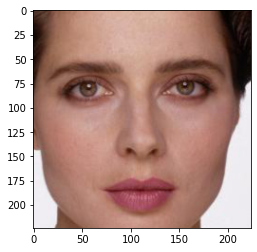

In [24]:
plt.imshow(np.transpose(western_all_images[0][0], (1, 2, 0)));

In [9]:
 _, _, asian_test_loader = train_val_test_split(type="test")

Running with Asian test data!
	Train size: 0 images
	Validation size: 0 images
	Test size: 208 images


In [10]:
test_loss = 0.0
asian_all_losses = []
print(f"\tTesting model with target {target}")
with torch.no_grad():
    model.eval()
    for images, height, weight, bmi in asian_test_loader:
        images, height, weight, bmi = images.to(device), height.to(device), weight.to(device), bmi.to(device)
        predictions = model(images)
        if target == "bmi":
            loss, all_loss  = test_criterion(predictions, bmi)
        elif target == "height":
            loss, all_loss = test_criterion(predictions, height)
        elif target == "weight":
            loss, all_loss = test_criterion(predictions, weight)
        test_loss += loss.item()*images.size(0)
        asian_all_losses +=  all_loss.squeeze().tolist()

# average test loss
test_loss = test_loss/len(asian_test_loader.sampler)
print(f"\tTesting loss with {type} data is: {test_loss:.3f}")

Testing model with target bmi
	Testing loss with west data is: 3.170


In [14]:
t = list(range(1, len(western_all_losses)+1))
df_western = pd.DataFrame(list(zip(t, western_all_losses)), columns=['Sample-th', 'Test loss'])
print(df_western['Test loss'].describe())

count    206.000000
mean       2.187038
std        2.556840
min        0.006624
25%        0.762773
50%        1.469013
75%        2.769943
max       19.638540
Name: Test loss, dtype: float64


In [15]:
t = list(range(1, len(asian_all_losses)+1))
df_asian = pd.DataFrame(list(zip(t, asian_all_losses)), columns=['Sample-th', 'Test loss'])
print(df_asian['Test loss'].describe())

count    208.000000
mean       3.170377
std        2.212229
min        0.019562
25%        1.492668
50%        2.976602
75%        4.336589
max       12.460855
Name: Test loss, dtype: float64


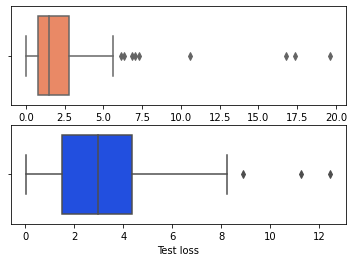

In [16]:
fig, axs = plt.subplots(nrows=2)
sns.set_palette("bright")
sns.boxplot(df_western['Test loss'], color="coral", ax=axs[0]);
sns.boxplot(df_asian['Test loss'], ax=axs[1]);

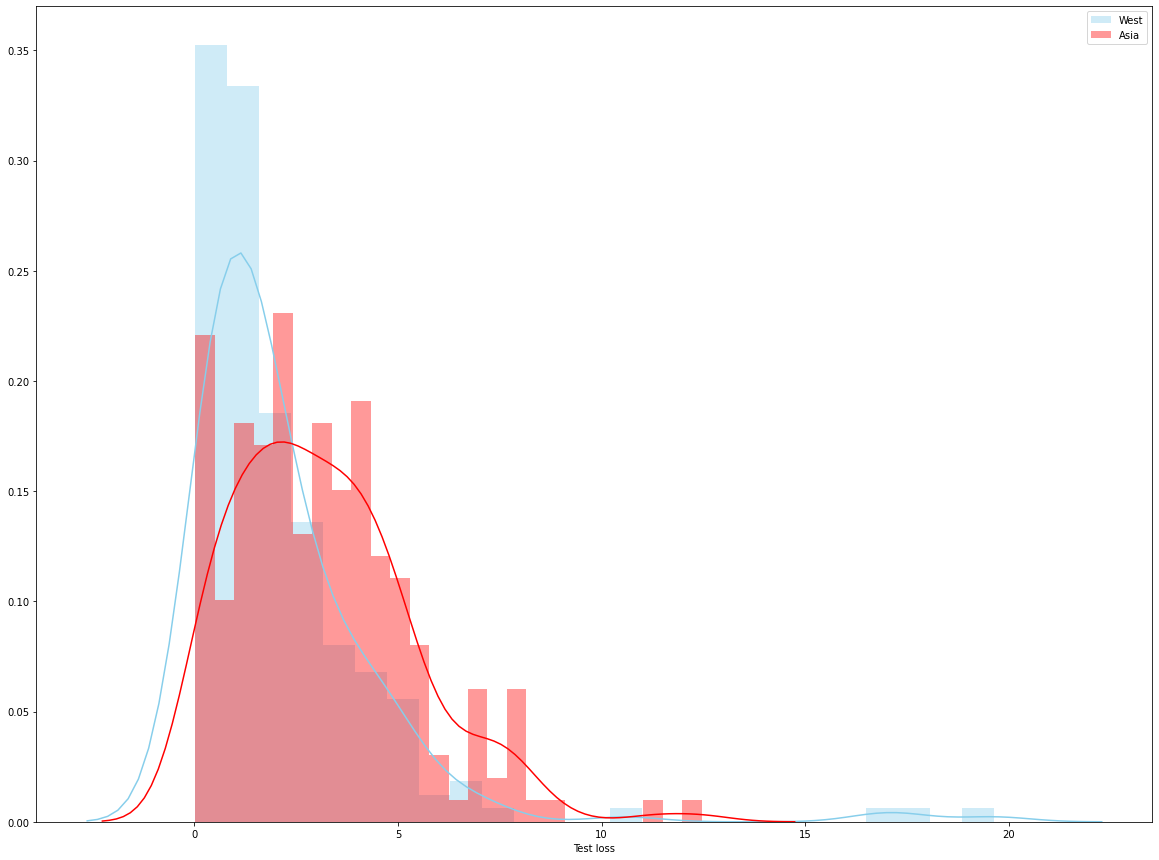

In [24]:
plt.figure(figsize=(20,15))
ax = sns.distplot(df_western['Test loss'], color="skyblue", label="West", bins=int(len(western_all_losses)/8))
ax = sns.distplot(df_asian['Test loss'], color="red", label="Asia", bins=int(len(asian_all_losses)/8))
ax.legend();
fig = ax.get_figure()
fig.savefig("../output/bmi_west_vs_asia.png")